In [86]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio

type = torch.float64
device = torch.device("cuda:0")

weights = scio.loadmat("../MATLABtest/volume_weights.mat")
pw1 = torch.tensor(weights["pw1"], dtype=type, device=device)
pb1 = torch.squeeze(torch.tensor(weights["pb1"], dtype=type, device=device))
pw2 = torch.tensor(weights["pw2"], dtype=type, device=device)
pb2 = torch.squeeze(torch.tensor(weights["pb2"], dtype=type, device=device))

In [87]:
model = torch.nn.Sequential(torch.nn.Linear(3,500, device=device), torch.nn.Sigmoid(), torch.nn.Linear(500,1, device=device))

model[0].weight = torch.nn.Parameter(pw1)
model[0].bias = torch.nn.Parameter(pb1)
model[2].weight = torch.nn.Parameter(pw2)
model[2].bias = torch.nn.Parameter(pb2)

In [88]:
class Poly1(torch.nn.Module):
    def __init__(self,dimension):
        super().__init__()
        self.dim = dimension

    def forward(self, x):
        # return poly(1, self.dim)
        return -torch.log(1 - (-torch.exp(x)))

class Qnet(torch.nn.Module):
    def __init__(self, dimension):
        super().__init__()
        with torch.no_grad():
            self.model = torch.nn.Sequential(torch.nn.Linear(dimension+1, 2**dimension, bias=False, dtype=type, device=device), 
            Poly1(dimension), 
            torch.nn.Linear(2**dimension, 1, bias=False, dtype=type,device=device))

        tpp = []
        for i in np.arange(0, 2**dimension, 1):
            tpp.append(list(np.binary_repr(i, width=dimension)))
        
        tpp = np.array(tpp).astype(float)
        S = torch.tensor(np.concatenate(((tpp == 0) * -1 + tpp, np.full((2**dimension, 1), -1)), axis=1), dtype=type, device=device)
        w3 = (-torch.prod(S, axis=1).T).reshape(1,S.size(0))

        self.model[0].weight = torch.nn.Parameter(S)
        self.model[2].weight = torch.nn.Parameter(w3)

    def forward(self, x):
        return self.model(x)

class Intergrator1():
    def __init__(self):
        self.qnet = Qnet(1)

    def apply(self, W1, B1, W2, B2, start = -1, end = 1):
        self.qnet.model[0].weight[0][0] = -end
        self.qnet.model[0].weight[1][0] = -start
        y = torch.cat((W1, B1.reshape(W1.size(0),1)), axis=1)
        res = torch.div(self.qnet(y), torch.prod(W1, axis = 1).reshape(W1.size(0),1)) + end-start
        self.model = torch.nn.Linear(W2.size(1),1, dtype=type,device=device)
        self.model.weight = torch.nn.Parameter(W2)
        self.model.bias = torch.nn.Parameter(B2*(end-start))#2**self.dim))

        return self.model(res.T)

tensor([[0.9005]], device='cuda:0', dtype=torch.float64)


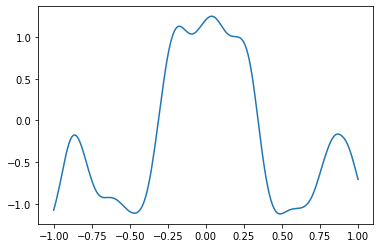

In [99]:
yslice = 0
zslice = 0

xs = np.reshape(np.linspace(-1,1,200),(200,1))
ys = np.reshape(np.linspace(yslice,yslice,200), (200,1))
zs = np.reshape(np.linspace(zslice,zslice,200), (200,1))

data = torch.tensor(np.concatenate((xs,ys,zs), axis=1), dtype=type, device=device)

# Maginalising the Z and Y dimensions
intDim = pw1[:,2:] # get the x weights 
slicedDims = pw1[:, :2] # get the z and y weights

constants = torch.tensor([yslice,zslice],dtype=type, device=device)

newb1 = pb1 + slicedDims.matmul(constants) # update bais

# print(newb1)

# print(intDim)

start = -1
stop = 0

with torch.no_grad():
    res = model(data).cpu().detach().numpy()
    qnet = Intergrator1()
    print(qnet.apply(intDim, newb1, pw2, pb2, start, stop))

plt.plot(np.reshape(np.linspace(-1,1,200), (200,1)), res)


In [28]:
print(qnet.qnet.model[0].weight)
print(qnet.qnet.model[0].bias)

print(qnet.qnet.model[2].weight)

Parameter containing:
tensor([[-1., -1.],
        [ 1., -1.]], requires_grad=True)
None
Parameter containing:
tensor([[-1.,  1.]], requires_grad=True)
